# FELion Spectra
New Baseline correction and analysing method for FELion Spectra

In [191]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d as interpolate
from peakutils import indexes as peak_index
import rampy as rp
import matplotlib.ticker as mtick
import os

In [192]:
%matplotlib inline
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=(100)

# Custom definitions

In [106]:
def peakfind(x, y, \
             file,\
             threshold=0.5, gap=30, show=True, marker=10, \
             ylabel='Intensity Normalised', \
             title = 'Spectrum'):
    
    indexes = peak_index(y, thres=threshold, min_dist=gap)    
    plt.figure()

    plt.plot(x, y)
    plt.plot(x[indexes], y[indexes],'+',ms=marker, label = 'peaks')

    for i in indexes:
        plt.annotate('%.2f'%x[i],xy=(x[i], y[i]), xytext=(x[i], y[i]))

    plt.legend()
    plt.xlabel('wavenumber $cm-1$')
    plt.ylabel(ylabel)
    plt.title(title+': %s'%file)

    if show: plt.show()
    plt.close()
        
    return x[indexes], y[indexes], indexes

# Making the plot vertical

In [231]:
def vertical_plot(filename, show=True):
    data = np.genfromtxt(filename)
    x, y = data[:,0], data[:,2]
    shape = data.shape[0]
    y1 = y.max()-y 

    plt.figure()

    plt.subplots_adjust(top=0.8,hspace = 0.5)

    plt.suptitle("Converting to Vertical\n Filename: %s"%filename, fontsize = v['mainfont'])

    plt.subplot(211)
    plt.plot(x, y)
    plt.title("A) Original Spectra", fontsize = v['subfont'])

    plt.subplot(212)
    plt.plot(x, y1)
    plt.title("B) Inverted Spectra", fontsize = v['subfont'])

    if show: plt.show()
    plt.close()
    return x, y, y1, data

# Baseline Correction (using "automatic least square fitting following Eilers and Boelens 2005")

**P.H. Eilers, H.F. Boelens, Baseline correction with asymmetric least squares smoothing. Leiden University Medical Centre Report, 2005; 1, 5.**
[Google Scholar](http://scholar.google.com/scholar?hl=en&q=P.H.+Eilers%2C+H.F.+Boelens%2C+Baseline+correction+with+asymmetric+least+squares+smoothing.+Leiden+University+Medical+Centre+Report%2C+2005%3B+1%2C+5.
)


We can control the baseline using lambda, p, niter parameters

In [145]:
def lambda_check(x, y1, filename=''):
    
    plt.figure()

    for i in range(4, 10):
        lamb = 10**i
        y_param, b_param = rp.baseline(x, y1,bir,"als",lam = lamb)
        plt.plot(x, y1, '-k')
        plt.plot(x, b_param, label = r'$\lambda$: $10^%s$'%i)

    plt.legend()
    plt.title("Baseline for %s\n Check for appropriate $\lambda$ value"%filename)
    plt.show()
    plt.close()

In [109]:
def baseline_correction(x, y1, show=True):

    y_corrected, baseline = rp.baseline(x, y1,bir,"als",lam = v['lamb'], p = v['p_value'], niter = v['iterations'])
    
    shape = len(x)

    plt.figure()
    plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.5)
    plt.suptitle("Baseline Correction\n Filename: %s"%filename, fontsize = v['mainfont'])

    plt.subplot(221)
    plt.plot(x, y1)
    plt.plot(x,baseline,label="baseline")
    plt.title("A) Baseline", fontsize = v['subfont'])
    plt.legend()

    plt.subplot(222)
    y_corrected = y_corrected-y_corrected.min()
    plt.plot(x,y_corrected,label="corrected signal")
    plt.title("B) Corrected", fontsize = v['subfont'])
    plt.ylim(ymin=0)
    plt.legend()

    plt.subplot(223)
    y_temp, y_smooth = rp.baseline(x, y_corrected,bir,"als",lam = v['smooth'])
    plt.plot(x,y_corrected, label = 'corrected signal')
    plt.plot(x, y_smooth, label = 'Reduced noise')
    plt.title("C) Noise Correction", fontsize = v['subfont'])
    plt.ylim(ymin=0)
    plt.legend()

    plt.subplot(224)
    plt.plot(x, y_smooth, label = 'Reduced noise')
    plt.title("D) Reduced noise", fontsize = v['subfont'])
    plt.ylim(ymin=0)
    plt.legend()

    if show: plt.show()
    plt.close()

    #Reshaping all the vaiables
    x = x.reshape(shape,)
    y1 = y1.reshape(shape,)
    baseline = baseline.reshape(shape,)
    y_corrected = y_corrected.reshape(shape,)
    y_smooth = y_smooth.reshape(shape,)
    
    return baseline, y_corrected, y_smooth

#  Calculating the counts Drop Percentage

Calculating the ion drop count value using the baseline.

The drop count percentage can be calculate from the original spectra.

In [110]:
def count_drop(x,y,y1, baseline, show=True):    
    counts_drop = y1-baseline
    original_baseline = y+counts_drop

    counts_drop_percentage = ((original_baseline-y)/original_baseline)*100
    counts_drop_percentage = counts_drop_percentage.astype(np.int)

    plt.figure()

    plt.suptitle("Calculating the counts Drop Percentage\n Filename: %s"%filename, fontsize = v['mainfont'])
    plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.5)

    plt.subplot(221)
    plt.plot(x, y1)
    plt.plot(x, baseline)
    plt.title("A) Inverted Spectrum", fontsize = v['subfont'])
    plt.ylabel('Counts')

    plt.subplot(222)
    plt.plot(x, y, label = 'original spectra')
    plt.plot(x, original_baseline)
    plt.title("B) Original Spectrum", fontsize = v['subfont'])
    plt.ylabel('Counts')

    plt.subplot(2,2,(3,4))
    plt.plot(x, counts_drop_percentage, label = 'counts drop %')
    plt.title("C) Count drop percentage", fontsize = v['subfont'])
    plt.ylabel('Counts drop (%)')
    plt.legend()

    plt.xlabel('wavenumber $cm-1$')

    if show: plt.show()
    plt.close()
    return counts_drop_percentage

# Finding Peaks

# Power Calibration

Assuming the drop counts should be the same for all the runs and it is dependent on Power.
We normalise the signal as 

Normalised_Intensity = drop count (%) / Power (mJ)

In [111]:
def power_calibrator(powerfile,x,counts_drop_percentage, show=True):
    
    f = open(powerfile)
    
    for i in f:
        if i.find('#SHOTS')>=0:
            shots=i.strip().split('=')[-1]
            break
    f.close()
    
    shots = np.float(shots)
    
    power_file = np.genfromtxt(powerfile)
    power_file_extrapolate = interpolate(power_file[:,0], power_file[:,1], kind = 'linear', fill_value = 'extrapolate')
    power_extrapolated = power_file_extrapolate(x)

    plt.figure()
    plt.suptitle("Power calibration\n Filename: %s"%powerfile, fontsize = v['mainfont'])
    plt.subplots_adjust(top = 0.8, wspace = 0.2, hspace = 0.5)

    plt.subplot(211)
    plt.plot(power_file[:,0], power_file[:,1], 'ok',ms=7, label='power from .pow file')
    plt.plot(x, power_extrapolated, '-', label='extrapolated values')
    plt.legend()
    plt.title('Power Extrapolation from .pow file')
    plt.ylabel('Power (mJ)')

    plt.subplot(212)
    y_normalised = (counts_drop_percentage/(power_extrapolated*shots))

    plt.plot(x, y_normalised, label = 'power calibrated, shots: %i'%shots)
    plt.xlabel(r'Wavenumber ($cm^{-1}$)')
    plt.ylabel('Normalised')
    plt.legend()

    if show: plt.show()
    plt.close()
    
    return power_extrapolated, y_normalised

In [201]:
os.chdir(r'D:\SurfDrive\backup_for_surfacePro\FELion-Spectrum-Analyser\testing\DATA')

In [227]:
#filename = "16_11_18-4.felix"
#powerfile = '16_11_18-4.pow'

v = {'lamb':10e9, 'smooth':0.05, 'p_value':0.01, 'iterations':10, 'mainfont':15, 'subfont':12}
bir = np.array([[1350, 1550, 1750]])
show_plot = False

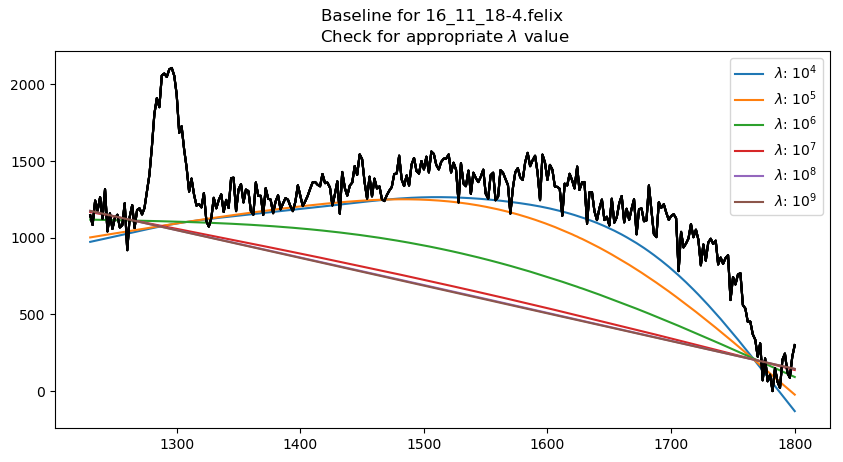

In [234]:
x, y, y1, data = vertical_plot(filename, show=show_plot)
lambda_check(x, y1, filename =filename)

In [229]:
v['lamb'] = 10e2

baseline, y_corrected, y_smooth = baseline_correction(x,y1, show=show_plot)

counts_drop_percentage = count_drop(x, y, y1, baseline, show=show_plot)

peakX, peakY, index = peakfind(x, counts_drop_percentage,file = filename, show=show_plot)

power_extrapolated, y_normalised = power_calibrator(powerfile,x, counts_drop_percentage, show=show_plot)

In [230]:
pwd = os.listdir()
files = []
for i in pwd:
    if i.find('.felix')>=0:
        files.append(i.split('.')[0])
powerfiles, felixfiles = [i+'.pow' for i in files], [i+'.felix' for i in files]
powerfiles, felixfiles

(['16_11_18-2.pow',
  '16_11_18-3.pow',
  '16_11_18-4.pow',
  '16_11_18-6.pow',
  '19_11_18-7.pow',
  '19_11_18-8.pow',
  '19_11_18-9.pow'],
 ['16_11_18-2.felix',
  '16_11_18-3.felix',
  '16_11_18-4.felix',
  '16_11_18-6.felix',
  '19_11_18-7.felix',
  '19_11_18-8.felix',
  '19_11_18-9.felix'])